# House Prices - Advanced Regression Techniques

ML 모델을 통한 회귀 분석을 통해 주택 가격을 예측하는 프로젝트입니다.  
해당 데이터셋은 Iowa 주 Ames에 있는 주거용 주택의 거의 모든 요소를 설명하는 79개의 설명 변수가 존재합니다.

출처 : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description  


- 해당 데이터셋을 선정한 이유

  > AI 부트캠프를 진행하면서 2번의 머신러닝을 이용한 프로젝트를 수행할 기회가 있었습니다. 한번은 Catboost 모델을 활용한 분류 문제 해결, 다른 한번은 회귀 모델을 탑재한 파이썬 앱을 개발하는 것이였습니다. 두번째 프로젝트는 웹 앱 개발 및 배포가 주 목적인 프로젝트였기 때문에 비교적 간단한 파이프라인을 구축했었고 분석을 위한 가설 검정 및 절차가 제대로 이루어지지 않았습니다. 이번 프로젝트에서는 좀 더 심화된 모델 파이프라인을 구축하기 위해 지난 두 프로젝트에서 시도하지 못했던 다중공산성과 같은 문제의 해결 및 가설 검정, 분석 절차를 이해하기 위해 진행되었습니다.  




      

In [ ]:
# pandas-profiling 설치
!pip install pandas-profiling==2.7.1
!pip install category_encoders

In [ ]:
# 필요한 module import
from google.colab import drive
import warnings
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from category_encoders import OrdinalEncoder, TargetEncoder
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
# future warning ignore
warnings.filterwarnings(action='ignore')

In [ ]:
# Kaggle에서 데이터셋을 받아오기 위해 Google drive를 mount합니다.
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c house-prices-advanced-regression-techniques

In [ ]:
y_test = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
raw_data = pd.read_csv('train.csv')

In [ ]:
print('train data :', raw_data.shape, '\ntest features :', test.shape, '\ntest target :', y_test.shape)

train data : (1460, 81) 
test features : (1459, 80) 
test target : (1459, 2)


## 다중 선형 회귀 분석에서는 몇 가지 가정이 유효한지 확인해야 합니다.

- 선형성(Linearity) : 선형 회귀는 target과 각 feature 간의 관계가 선형이여야 합니다.
- 등분산성(Homoscedasticity) : 오차 또는 잔차가 무작위적인 변동이지만 동일성을 갖추어야 합니다.
- 다변량 정규성(Multivariate Normality) : 데이터가 정규성을 띄어야 합니다.
- 오류의 독립성(Independence of Errors) : 연속되는 관측 값끼리 상관 관계가 존재해선 안됩니다.
- 다중공산성(Multicollinearity) 문제 : feature끼리는 서로 독립적이여야 합니다(다중공산성 없음)  

  





아래의 과정에서 위 다섯 가지의 가정이 유효한지 확인해보겠습니다.

## Target 선정
- 무엇을 얻기 위해 이 데이터셋을 열었을까?
> 주택의 가격을 예측하고자 이 데이터셋을 열었습니다. 먼저 데이터에서 주택의 판매가격에 대해 알아보고자 합니다.  
Target과 features 간의 상관계수를 확인 후  pairplot을 통해 insight를 얻을 수 있는지 확인하겠습니다.

In [ ]:
target = 'SalePrice'
y = raw_data[[target]]
y

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [ ]:
raw_data.corr().SalePrice.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

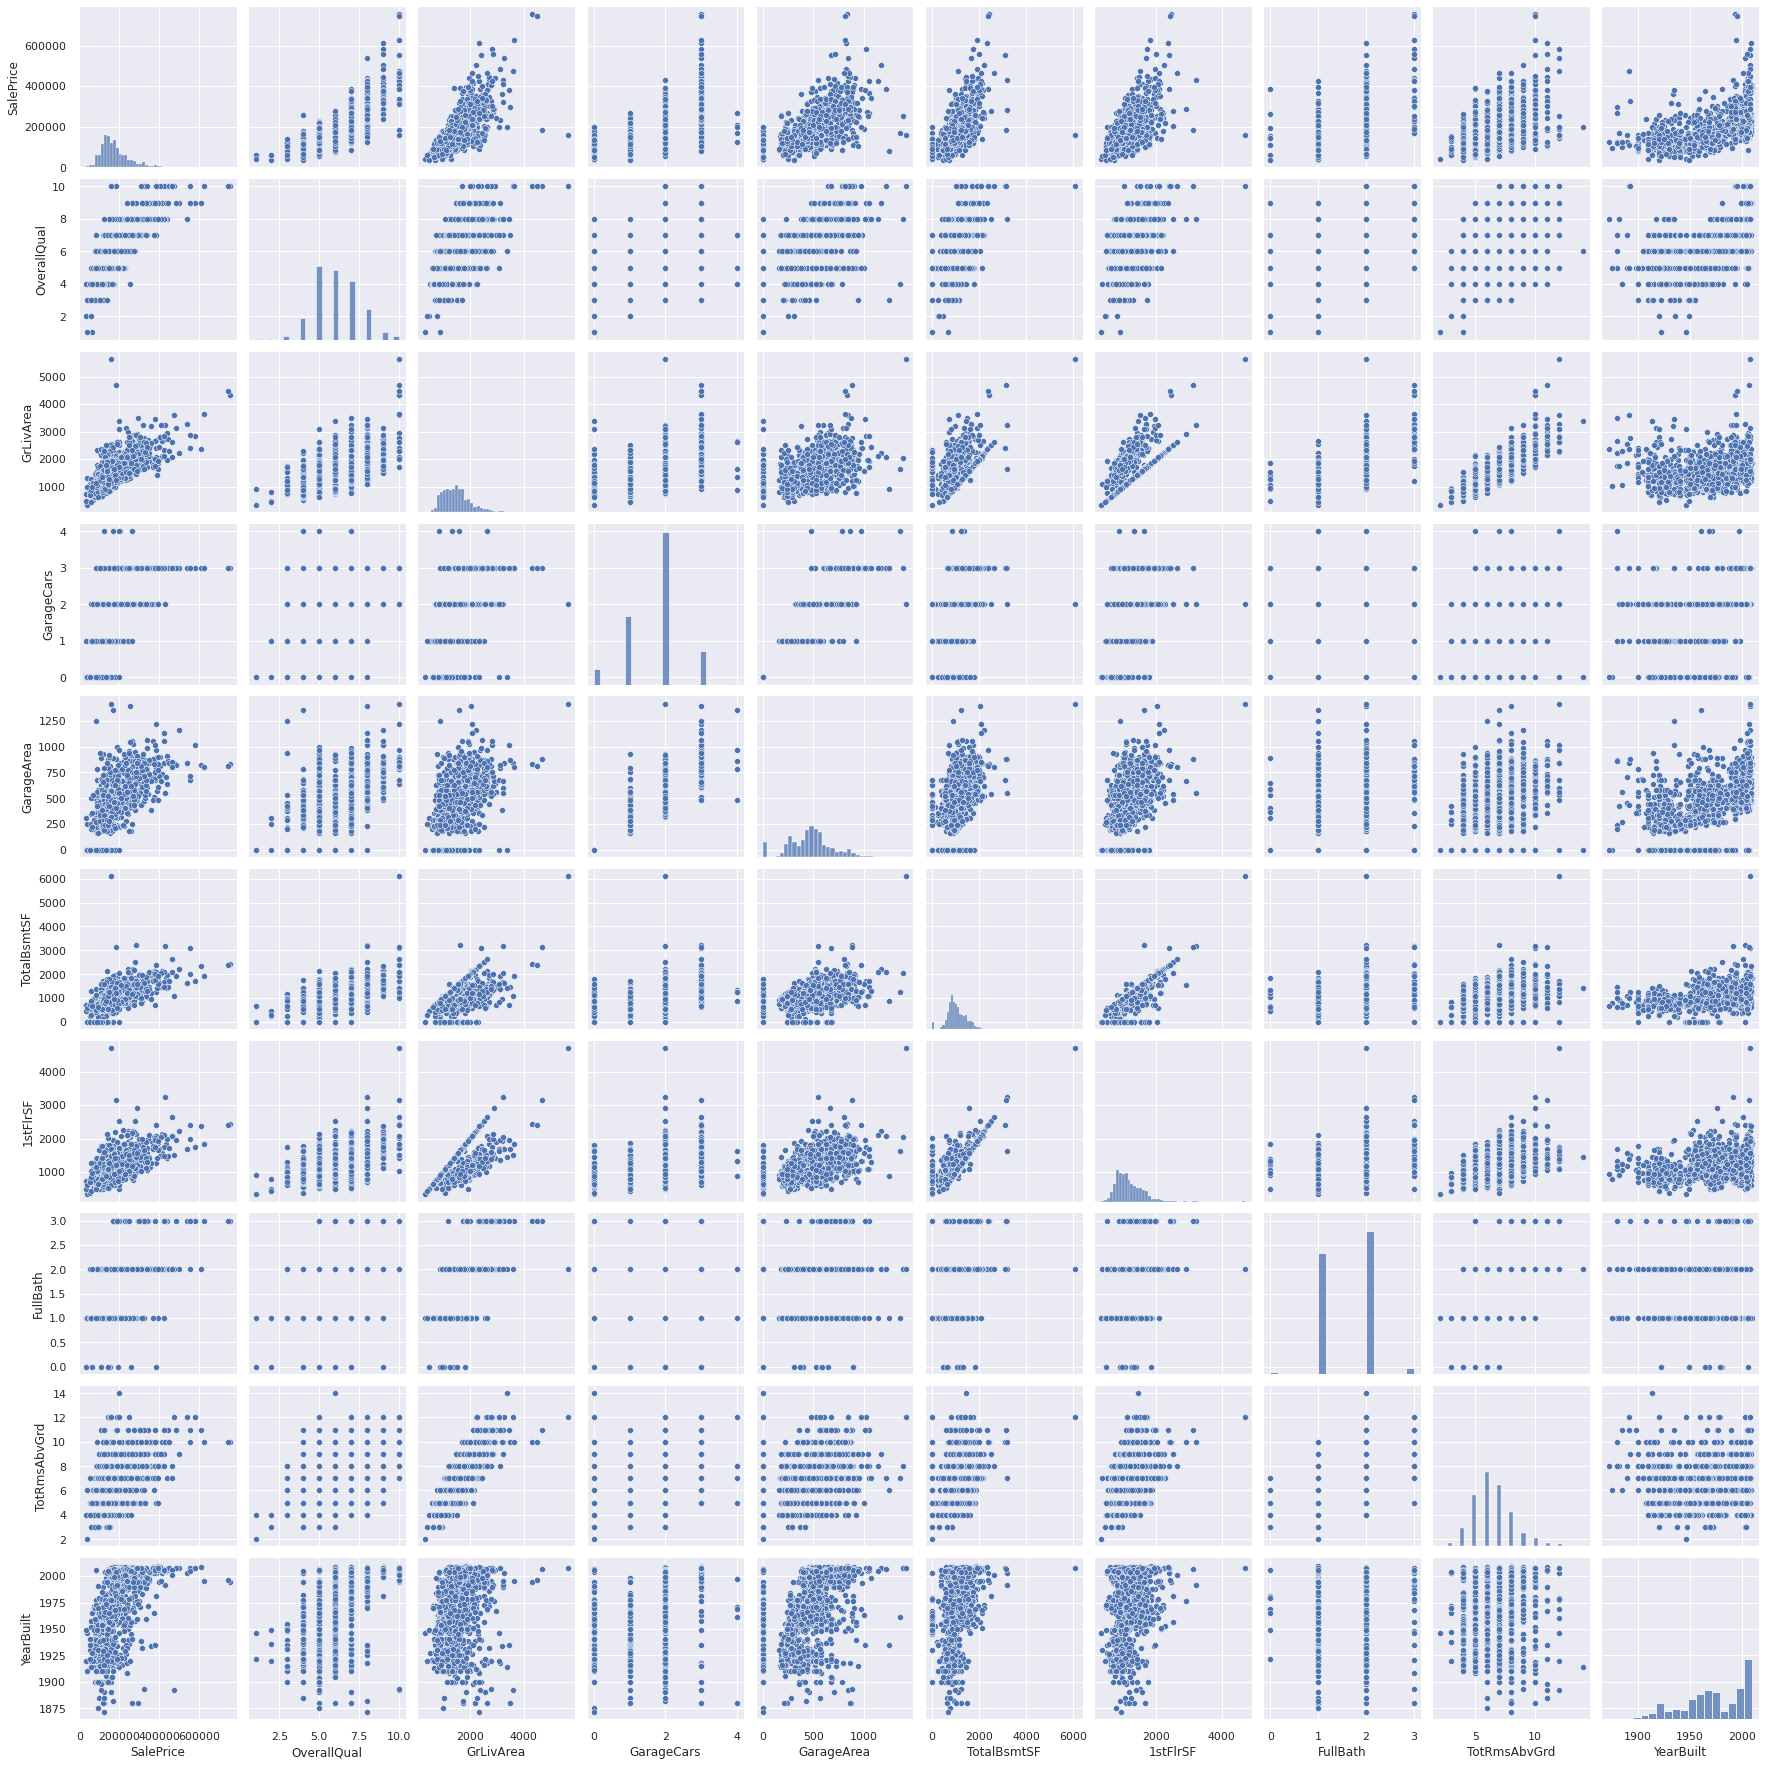

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.pairplot(raw_data[cols], size = 2.5)
plt.show();

### pairplot을 통해 얻을 수 있는 점
pairplot에 존재하는 모든 plot을 확인할 필요는 없습니다. 이중에서 'SalePrice'와 관련된 plot만 확인해보도록 하겠습니다. 첫번째 행에 존재하는 'SalePrice'를 제외한 9개의 plot입니다. 

- 이상치(Outlier)
> 대부분의 plot에서 점의 집합에서 동떨어진 점이 소수 보이고 있습니다('SalePrice'와 'GrLivArea'의 산점도에서 우측 하단의 두 점 등). 이는 이상치(Outlier)임을 뜻하며 선형 회귀는 이상치에 매우 민감하기 때문에 꼭 해결되어야 할 문제입니다.

- 선형성(Linearity)
> 대부분의 plot이 x축 값과 y축 값이 동시에 증가하는 모양을 띄고 있습니다.  
하지만 높은 수준의 선형성을 띄지 않고 아래에서 더 살펴볼 것이 있습니다.

- 이분산성(Heteroscedasticity)
> 대부분의 plot이 원뿔형 모양을 띄고 있으며 이는 'SalePrice' 값이 증가할 때 분산도 같이 증가하는 것이라 할 수 있습니다. 이는 feature의 분산이 동일성을 갖지 않다는 말과 같습니다. 이는 분석에서 중요한 요소인 등분산성을 위협하는 요소입니다.

## 등분산성과 target의 정규성을 확보하기 위한 절차

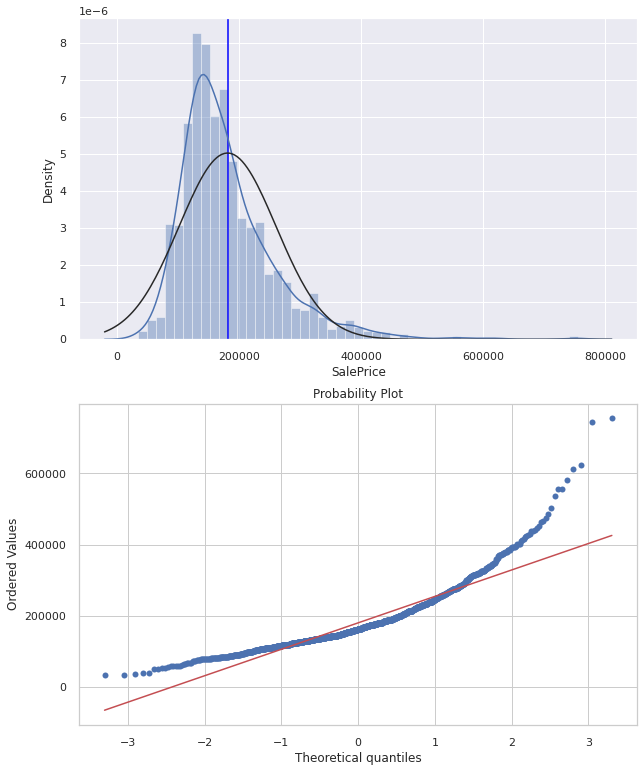

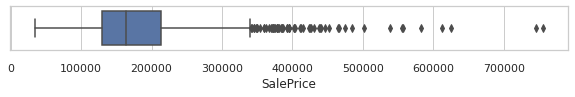

In [ ]:
plt.figure(figsize = (10, 13))

ax1 = plt.subplot(211)
sns.set_style("whitegrid")
plt.axvline(raw_data['SalePrice'].mean(), color='blue')
res = sns.distplot(raw_data['SalePrice'], fit = stats.norm);

ax2 = plt.subplot(212)
sns.set_style("whitegrid")
res = stats.probplot(raw_data['SalePrice'], plot=plt)

plt.show()

plt.figure(figsize = (10, 0.8))
sns.set_style("whitegrid")
sns.boxplot(x= raw_data['SalePrice'], orient = 'h');

In [ ]:
print('왜도 :', raw_data['SalePrice'].skew(), '\n첨도 :', raw_data['SalePrice'].kurt())

왜도 : 1.8828757597682129 
첨도 : 6.536281860064529


Target('SalePrice')의 분포에 관한 그림(Histogram, probability plot, box plot)입니다.  
분포도 및 박스가 왼쪽으로 치우쳐저 있는 것을 확인할 수 있습니다.  
등분산성과 정규성을 확보하기 위해 로그 변환을 취해주도록 하겠습니다.


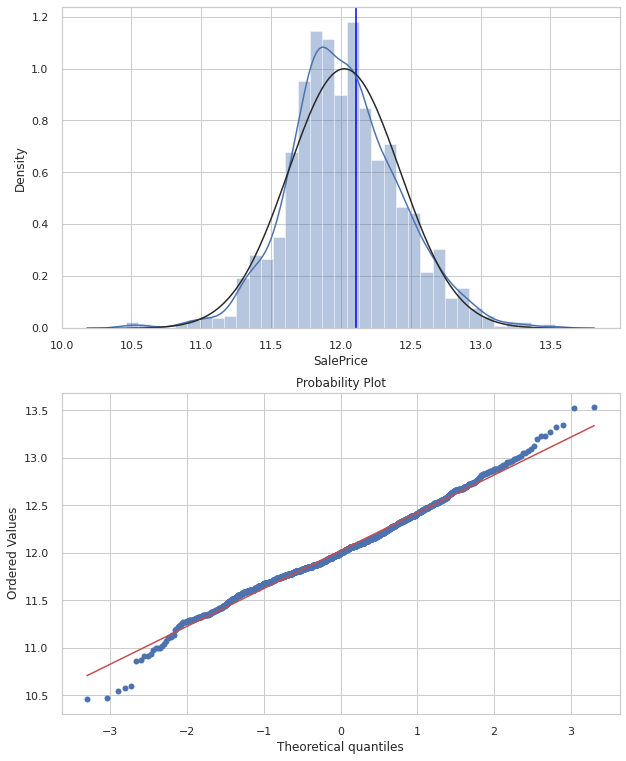

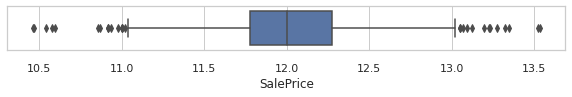

In [ ]:
plt.figure(figsize = (10, 13))

ax1 = plt.subplot(211)
sns.set_style("whitegrid")
plt.axvline(np.log1p(raw_data['SalePrice'].mean()), color='blue')
res = sns.distplot(np.log1p(raw_data['SalePrice']), fit = stats.norm);

ax2 = plt.subplot(212)
sns.set_style("whitegrid")
res = stats.probplot(np.log1p(raw_data['SalePrice']), plot=plt)

plt.show()

plt.figure(figsize = (10, 0.8))
sns.set_style("whitegrid")
sns.boxplot(x= np.log1p(raw_data['SalePrice']), orient = 'h');

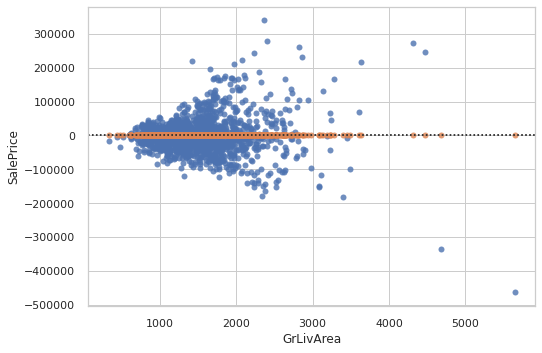

In [ ]:
sns.residplot(raw_data.GrLivArea, raw_data.SalePrice);
sns.residplot(raw_data.GrLivArea, np.log1p(raw_data.SalePrice));

로그 변환 후의 target의 분포도와 잔차도입니다.  
이전보다 훨씬 정규성을 확보한 것을 확인할 수 있습니다.  
잔차도에서 전(파란색)과 비교했을 때 후(주황색)이 등분산성 또한 확보한 것을 알 수 있습니다.

##다중공산성(Multicollinearity)
다중공산성을 알아보기 위한 heatmap입니다.  
'1stFlrSF'-'TotalBsmtSF', 'GarageArea'-'GarageCars'와 같이 특성(feature)끼리 굉장히 높은 상관계수(다중공산성)을 띄는 부분이 있습니다.  
다중공산성은 이를 보이는 특성을 병학/제거하는 방법으로 해결할 수 있습니다.  
또는 Ridge/Lasso 모델을 통한 Regularization 과정 중에 해결할 수 있습니다.  

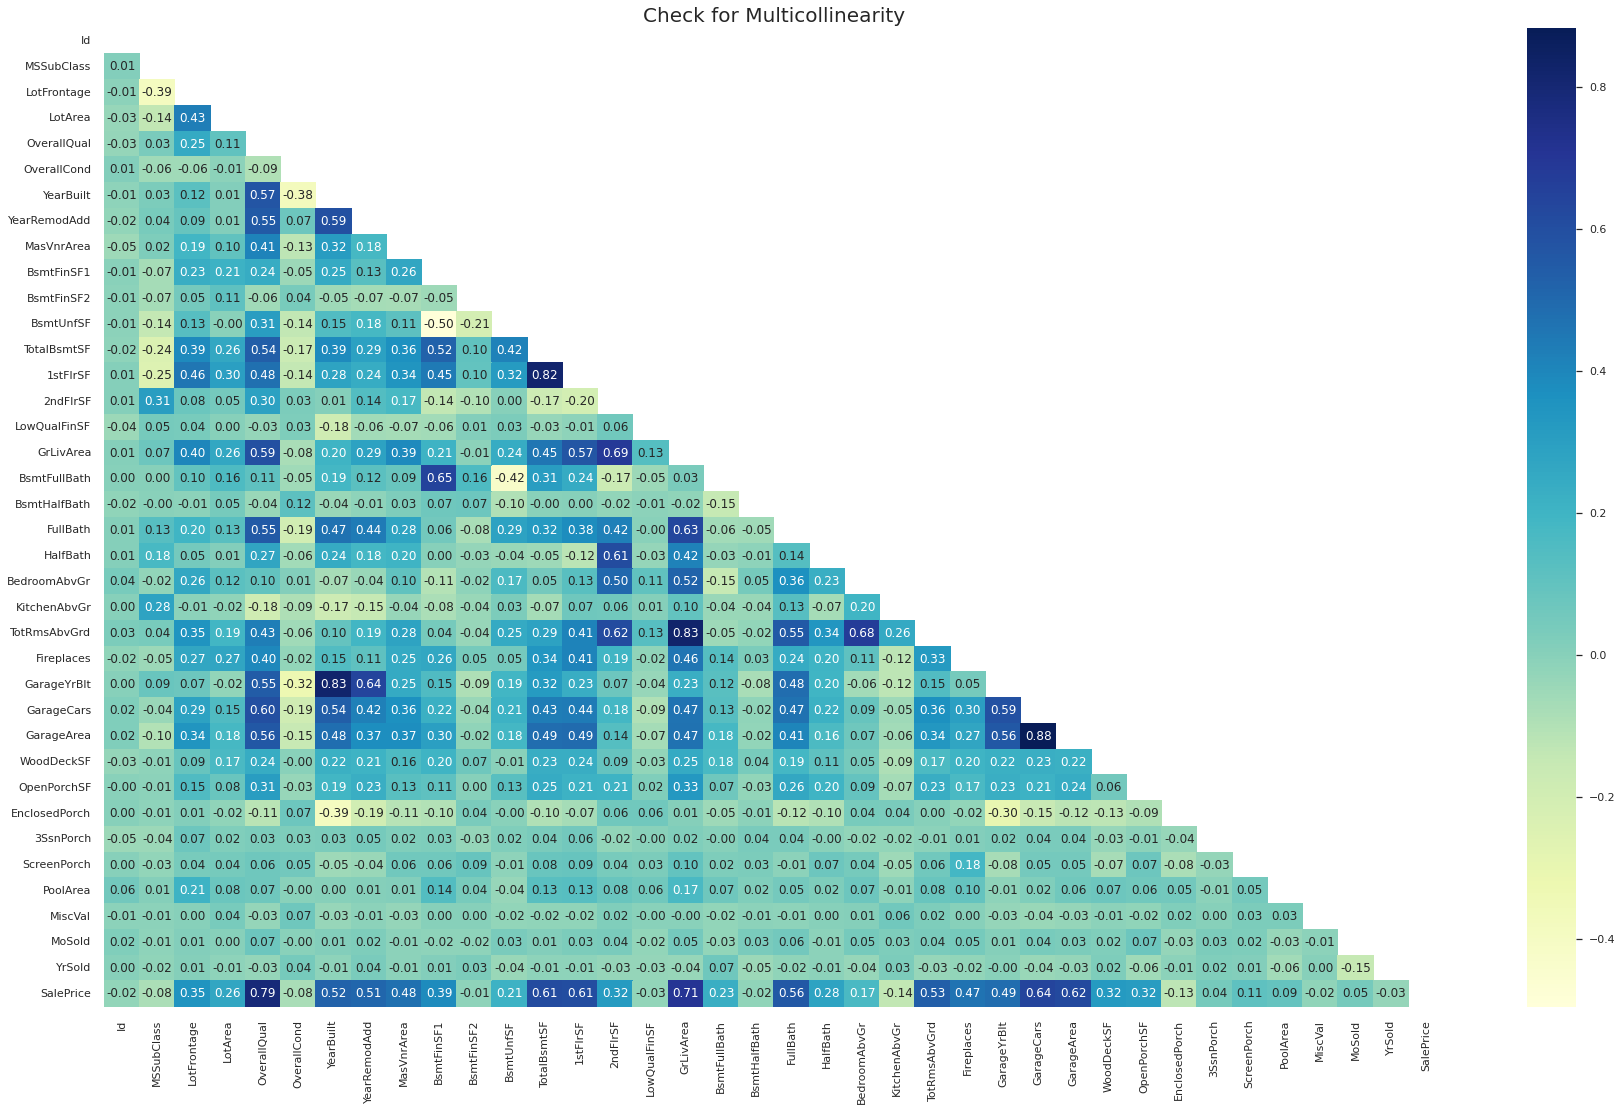

In [ ]:
mask = np.zeros_like(raw_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (30, 18))
sns.heatmap(raw_data.corr(), cmap='YlGnBu', annot=True, fmt = '.2f', mask=mask)
plt.title('Check for Multicollinearity', fontsize=20)
plt.show()

##데이터 전처리
데이터 클리닝(Data Cleaning)을 수행하기 위해 먼저 데이터에 대해 알아볼 필요가 있습니다.  
pandas_profiling 모듈을 통해 데이터의 전체적인 특징을 살펴보겠습니다.


In [ ]:
raw_data_profile = ProfileReport(raw_data, minimal = True).to_notebook_iframe()
raw_data_profile

Summarize dataset:   0%|          | 0/88 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
missing = raw_data.isnull().sum()
count = raw_data.isnull().count()
normalized = (missing / count).sort_values(ascending = False)
df_missing = pd.DataFrame(normalized, columns = ['missing_percentage'])

df_missing.head(20)

,missing_percentage
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageCond,0.055479
GarageType,0.055479
GarageFinish,0.055479


## 결측치(Missing data)
대부분의 feature가 결측치를 가지고 있지 않거나 매우 적은 양의 결측치를 갖고 있습니다.

결측치를 채우기 전에 전체 데이터 중 결측치 비율이 매우 높은 특성만 먼저 살펴보겠습니다.  

  - PoolQC : 수영장의 품질을 나타내는 특성입니다. 
  
  > 대부분의 상품이 수영장을 가지고 있지 않게 때문에 결측치가 많은 특성입니다. PoolArea 특성과 연관이 있어 보입니다. PoolArea 특성도 단 7개의 데이터를 제외하고 0 값을 나타내고 있습니다.

  - MiscFeature : 다른 특성으로 셀 수 없는 기타 특징입니다.
  
  - Alley : 상품에 접근할 수 있는 골목의 유형을 나타내는 특성입니다.
  
  > 대부분의 상품이 골목 접근이 제한되어 있습니다.  
  - Fence : 상품이 울타리를 갖고 있는지 나타내는 특성입니다.
    
  > 대부분의 상품이 울타리를 갖고 있지 않습니다.
  
  - FireplaceQu : 난로의 품질을 나타내는 특성입니다.
    
  > 전체 상품 중 약 절반가량(47%)이 난로를 가지고 있지 않습니다.
  
  - LotFrontage : 상품과 거리까지의 직선거리를 나타내는 특성입니다.

결측치의 비율이 높은 특성에 대해 결측치를 보간하면 통계적 분석에 영향을 끼칠 수 있습니다. 또한 대부분이 결측치인 특성은 통계적 분석에 영향을 끼치지 못합니다. 따라서 이러한 특성들은 제거해주도록 하겠습니다.  
'Street', 'Utilities'와 같이 범주형(Categorical) 변수를 갖지만 불균형도가 극심하여 분석에 의미없는 특성도 함께 제거하겠습니다.

In [ ]:
def removing_missing(df):
  df = df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'Street', 'Utilities'], axis = 1) # train Id = index + 1, test Id = index + 1461
  df[['MasVnrArea', 'GarageYrBlt']] = df[['MasVnrArea', 'GarageYrBlt']].fillna(0)
  df = df.fillna('None')
  
  return df

In [ ]:
df1 = removing_missing(raw_data)
df1 = df1.drop(['SalePrice'], axis = 1)
df1

,Id,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal
1456,1457,20,RL,13175,Reg,Lvl,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal
1457,1458,70,RL,9042,Reg,Lvl,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal
1458,1459,20,RL,9717,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal


## 왜도 보정
데이터셋이 모집단에서 추출되었다는 가정 하에 정규성을 띄어야 합니다.  
왜도가 심한 특성을 찾고 보정할 수 있도록 하겠습니다.

In [ ]:
numeric_features = df1.dtypes[df1.dtypes != "object"].index
skewed_features = df1[numeric_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)

skewed_features

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
Id                0.000000
GarageCars       -0.342197
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -3.865524
dtype: float64

In [ ]:
def fixing_skew(df):
  numeric_feats = df.dtypes[df.dtypes != "object"].index
  skewed_feats = df[numeric_feats].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
  
  high_skew = skewed_feats[abs(skewed_feats) > 1]

  for feat in high_skew.index:
    df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
  
  return df

In [ ]:
df2 = fixing_skew(df1)
df2

,Id,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,6.281283,RL,8.670456,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.340338,Gd,TA,PConc,Gd,TA,No,GLQ,118.098009,Unf,0.000000,150,252.446471,GasA,Ex,Y,SBrkr,5.133686,854,0.0,7.744829,1,0.000000,2,1,3,0.717357,Gd,8,Typ,0,Attchd,1.267265e+127,RFn,2,548,TA,TA,Y,0.000000,12.049772,0.000000,0.0,0.0,0.0,0.000000,2,2008,WD,Normal
1,2,4.146687,RL,8.787629,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,147.125753,Unf,0.000000,284,342.556447,GasA,Ex,Y,SBrkr,5.348117,0,0.0,7.416975,0,0.682506,2,0,3,0.717357,TA,6,Typ,1,Attchd,7.468955e+126,RFn,2,460,TA,TA,Y,62.298509,0.000000,0.000000,0.0,0.0,0.0,0.000000,5,2007,WD,Normal
2,3,6.281283,RL,8.933083,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.687636,Gd,TA,PConc,Gd,TA,Mn,GLQ,91.750444,Unf,0.000000,434,267.178842,GasA,Ex,Y,SBrkr,5.174048,866,0.0,7.791849,1,0.000000,2,1,3,0.717357,Gd,6,Typ,1,Attchd,1.218894e+127,RFn,2,608,TA,TA,Y,0.000000,9.878686,0.000000,0.0,0.0,0.0,0.000000,9,2008,WD,Normal
3,4,6.622580,RL,8.782836,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,52.861354,Unf,0.000000,540,228.937528,GasA,Gd,Y,SBrkr,5.198336,756,0.0,7.749245,1,0.000000,1,0,3,0.717357,Gd,7,Typ,1,Detchd,1.149693e+127,Unf,3,642,TA,TA,Y,0.000000,8.946970,19.032388,0.0,0.0,0.0,0.000000,2,2006,WD,Abnorml
4,5,6.281283,RL,9.150118,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.266438,Gd,TA,PConc,Gd,TA,Av,GLQ,112.267318,Unf,0.000000,490,317.335350,GasA,Ex,Y,SBrkr,5.295029,1053,0.0,8.016603,1,0.000000,2,1,4,0.717357,Gd,9,Typ,1,Attchd,1.195387e+127,RFn,3,836,TA,TA,Y,46.391564,14.232142,0.000000,0.0,0.0,0.0,0.000000,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,6.281283,RL,8.610572,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,Unf,0.000000,Unf,0.000000,953,274.688103,GasA,Ex,Y,SBrkr,5.193686,694,0.0,7.704258,0,0.000000,2,1,3,0.717357,TA,7,Typ,1,Attchd,1.172323e+127,RFn,2,460,TA,TA,Y,0.000000,9.621565,0.000000,0.0,0.0,0.0,0.000000,8,2007,WD,Normal
1456,1457,4.146687,RL,9.077728,Reg,Lvl,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,15.277561,TA,TA,CBlock,Gd,TA,No,ALQ,127.405887,Rec,8.337801,589,400.974824,GasA,TA,Y,SBrkr,5.612227,0,0.0,7.953152,1,0.000000,2,0,3,0.717357,TA,7,Min1,2,Attchd,7.769177e+126,Unf,2,500,TA,TA,Y,69.232041,0.000000,0.000000,0.0,0.0,0.0,0.000000,2,2010,WD,Normal
1457,1458,6.622580,RL,8.732655,Reg,Lvl,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.000000,Ex,Gd,Stone,TA,Gd,No,GLQ,62.328749,Unf,0.000000,877,318.859481,GasA,Ex,Y,SBrkr,5.315197,1152,0.0,8.084490,0,0.000000,2

In [ ]:
def feature_enginerring(df):
  df['TotalSF'] = (df['TotalBsmtSF'] +
                   df['1stFlrSF'] +
                   df['2ndFlrSF'])

  df['Total_sqr_footage'] = (df['BsmtFinSF1'] +
                             df['BsmtFinSF2'] +
                             df['1stFlrSF'] + 
                             df['2ndFlrSF'])
                                 
  df['Total_Bath'] = (df['FullBath'] +
                      df['BsmtFullBath'] + 
                     (df['HalfBath'] * 0.5) + 
                     (df['BsmtHalfBath'] * 0.5))
                               
  df['Total_porch_sf'] = (df['OpenPorchSF'] + 
                          df['3SsnPorch'] + 
                          df['EnclosedPorch'] +
                          df['ScreenPorch'] + 
                          df['WoodDeckSF'])
                              
  df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
  df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
  df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
  df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

  df = df.drop(['TotalBsmtSF', 
                'BsmtFinSF1', 
                'BsmtFinSF2', 
                '1stFlrSF', 
                '2ndFlrSF', 
                'FullBath', 
                'BsmtFullBath', 
                'HalfBath', 
                'BsmtHalfBath', 
                'OpenPorchSF', 
                '3SsnPorch', 
                'EnclosedPorch', 
                'ScreenPorch', 
                'WoodDeckSF', 
                'PoolArea', 
                'TotalBsmtSF', 
                'Fireplaces', 
                'GarageYrBlt', #Multicollinearity
                'GarageArea', #Multicollinearity
                'TotRmsAbvGrd'], axis = 1)
  
  # 이상치 제거
  for col in df.dtypes[df.dtypes == 'float64'].index:
    df[col] = df[df[col] < np.percentile(df[col], 99.5)][col]
  
  df = df.dropna()

  # 인코딩
  enc_ordinal = OrdinalEncoder(cols = ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'HeatingQC', 'KitchenQual', 'GarageFinish', 'GarageQual', 'PavedDrive', 'GarageCond'])
  df = enc_ordinal.fit_transform(df)

  return df

In [ ]:
df3 = feature_enginerring(df2)

y['SalePrice'] = y[y['SalePrice'] < np.percentile(y['SalePrice'], 99.5)]['SalePrice'].dropna()

temp = pd.concat([df3, y], axis=1).dropna().drop(['Id'], axis = 1)
y_temp = temp[['SalePrice']]
X_temp = temp.drop(['SalePrice'], axis = 1)

enc_target = TargetEncoder()

X = enc_target.fit_transform(X_temp, y_temp)
y = np.log1p(y_temp)

In [ ]:
X

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,Total_sqr_footage,Total_Bath,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,6.281283,189309.005671,8.670456,1.0,1.0,176762.093555,1.0,197468.899329,182803.436052,179787.415094,181478.394535,207194.759305,7.0,5.0,2003.0,2003.0,172108.921905,179410.13308,212588.882353,212779.617769,202454.485437,19.340338,1.0,1.0,221009.791935,1.0,1.0,1.0,1.0,1.0,150.0,180583.864226,1.0,1.0,185047.174267,0.0,7.744829,3.0,0.717357,1.0,182184.569712,200074.411125,1.0,2.0,1.0,1.0,1.0,0.0,2.0,2008.0,172093.523768,174444.276364,1111.580157,977.231695,3.500000,12.049772,0.0,1.0,1.0,1.0,0.0
1,4.146687,189309.005671,8.787629,1.0,1.0,180558.333333,1.0,224144.519183,142410.153846,179787.415094,181478.394535,176032.914580,6.0,8.0,1976.0,1976.0,172108.921905,179410.13308,150952.456410,151366.994737,156784.146650,0.000000,2.0,1.0,147742.038938,1.0,1.0,2.0,2.0,1.0,284.0,180583.864226,1.0,1.0,185047.174267,0.0,7.416975,3.0,0.717357,2.0,182184.569712,200074.411125,1.0,2.0,1.0,1.0,1.0,0.0,5.0,2007.0,172093.523768,174444.276364,347.904564,152.473870,2.341253,62.298509,0.0,0.0,1.0,1.0,1.0
2,6.281283,189309.005671,8.933083,2.0,1.0,176762.093555,1.0,197468.899329,182803.436052,179787.415094,181478.394535,207194.759305,7.0,5.0,2001.0,2002.0,172108.921905,179410.13308,212588.882353,212779.617769,202454.485437,17.687636,1.0,1.0,221009.791935,1.0,1.0,3.0,1.0,1.0,434.0,180583.864226,1.0,1.0,185047.174267,0.0,7.791849,3.0,0.717357,1.0,182184.569712,200074.411125,1.0,2.0,1.0,1.0,1.0,0.0,9.0,2008.0,172093.523768,174444.276364,1138.352889,962.924492,3.500000,9.878686,0.0,1.0,1.0,1.0,1.0
3,6.622580,189309.005671,8.782836,2.0,1.0,179431.248945,1.0,209927.488889,182803.436052,179787.415094,181478.394535,207194.759305,7.0,5.0,1915.0,1970.0,172108.921905,179410.13308,145072.189189,147987.878788,156784.146650,0.000000,2.0,1.0,129222.669231,2.0,2.0,1.0,2.0,1.0,540.0,180583.864226,2.0,1.0,185047.174267,0.0,7.749245,3.0,0.717357,1.0,182184.569712,133047.340116,2.0,3.0,1.0,1.0,1.0,0.0,2.0,2006.0,172093.523768,141497.731183,990.135863,814.059690,2.000000,27.979358,0.0,1.0,1.0,1.0,1.0
4,6.281283,189309.005671,9.150118,2.0,1.0,180558.333333,1.0,305029.945946,182803.436052,179787.415094,181478.394535,207194.759305,8.0,5.0,2000.0,2000.0,172108.921905,179410.13308,212588.882353,212779.617769,202454.485437,25.266438,1.0,1.0,221009.791935,1.0,1.0,4.0,1.0,1.0,490.0,180583.864226,1.0,1.0,185047.174267,0.0,8.016603,4.0,0.717357,1.0,182184.569712,200074.411125,1.0,3.0,1.0,1.0,1.0,0.0,12.0,2008.0,172093.523768,174444.276364,1375.630380,1170.562347,3.500000,60.623705,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,4.146687,189309.005671,9.322277,1.0,1.0,176762.093555,1.0,155244.780488,182803.436052,179787.415094,181478.394535,176032.914580,5.0,5.0,2006.0,2006.0,172108.921905,179410.13308,212588.882353,212779.617769,156784.146650,0.000000,2.0,1.0,221009.791935,1.0,1.0,1.0,4.0,1.0,1140.0,180583.864226,1.0,1.0,185047.174267,0.0,7.307504,3.0,0.717357,2.0,182184.569712,94307.627119,4.0,0.0,3.0,4.0,1.0,0.0,7.0,2006.0,172093.523768,141497.731183,321.538083,5.292631,1.000000,26.238361,0.0,0.0,0.0,1.0,0.0
1454,4.146687,214220.857143,8.560812,1.0,1.0,176762.093555,1.0,225805.547619,182803.436052,179787.415094,

In [ ]:
y

,SalePrice
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220
...,...
1453,11.344519
1454,12.128117
1455,12.072547
1456,12.254868


## Machine Learning Model Pipeline


In [ ]:
# Baseline

y_train = y['SalePrice']
baseline = y['SalePrice'].mean()
y_pred_bl = [baseline] * len(y_train)

np.sqrt(mean_squared_error(y_train, y_pred_bl))

0.3862128408078641

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
alphas1 = np.arange(14., 16., .1)
alphas2 = np.arange(0.0001, 0.001, .0001)

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas1, cv=kfolds))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=10000000,
                                              alphas=alphas2, 
                                              random_state=42, 
                                              cv=kfolds))

xgbreg = make_pipeline(RobustScaler(), XGBRegressor(learning_rate=0.02, 
                                                      n_estimators=5000, 
                                                      max_depth=7, 
                                                      min_child_weight=0, 
                                                      gamma=0, 
                                                      subsample=0.7, 
                                                      colsample_bytree=0.7, 
                                                      objective='reg:squarederror', 
                                                      nthread=-1, 
                                                      scale_pos_weight=1, 
                                                      seed=42, 
                                                      reg_alpha=0.00006))

rfreg = make_pipeline(RobustScaler(), RandomForestRegressor(n_estimators=1000, 
                                                              criterion="squared_error", 
                                                              max_depth=7, 
                                                              min_samples_split=2, 
                                                              min_samples_leaf=1, 
                                                              min_weight_fraction_leaf=0, 
                                                              max_features="auto",  
                                                              n_jobs=-1, 
                                                              random_state=42, 
                                                              max_samples=10))

In [ ]:
score1 = cv_rmse(ridge)
score2 = cv_rmse(lasso)
score3 = cv_rmse(xgbreg)
score4 = cv_rmse(rfreg)

print("Ridge: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("LASSO: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))
print("xgboost: {:.4f} ({:.4f})\n".format(score3.mean(), score3.std()))
print("RandomForest: {:.4f} ({:.4f})\n".format(score4.mean(), score4.std()))

Ridge: 0.1148 (0.0158)

LASSO: 0.1135 (0.0154)

xgboost: 0.1139 (0.0149)

RandomForest: 0.2254 (0.0268)



In [ ]:
ridge_model = ridge.fit(X, y)
lasso_model = lasso.fit(X, y)
xgbreg_model = xgbreg.fit(X, y)
rfreg_model = rfreg.fit(X, y)

In [ ]:
def blending_models(X):
  return (
      (0.3 * ridge_model.predict(X)).reshape(-1, ) + 
      (0.3 * lasso_model.predict(X)) + 
      (0.3 * xgbreg_model.predict(X)) + 
      (0.1 * rfreg_model.predict(X))
  )
  
print('RMSLE score on train data:')
print(rmsle(y, blending_models(X)))

RMSLE score on train data:
0.07848853327931868


In [ ]:
X_test = removing_missing(test)
X_test = fixing_skew(X_test)

X_test['TotalBsmtSF'] = X_test['TotalBsmtSF'].apply(pd.to_numeric, errors = 'coerce')
X_test['TotalBsmtSF'] = X_test['TotalBsmtSF'].fillna(X_test['TotalBsmtSF'].mean())
X_test['BsmtFinSF1'] = X_test['BsmtFinSF1'].apply(pd.to_numeric, errors = 'coerce')
X_test['BsmtFinSF1'] = X_test['BsmtFinSF1'].fillna(X_test['BsmtFinSF1'].mean())
X_test['BsmtFinSF2'] = X_test['BsmtFinSF2'].apply(pd.to_numeric, errors = 'coerce')
X_test['BsmtFinSF2'] = X_test['BsmtFinSF2'].fillna(X_test['BsmtFinSF2'].mean())
X_test['BsmtFullBath'] = X_test['BsmtFullBath'].apply(pd.to_numeric, errors = 'coerce')
X_test['BsmtFullBath'] = X_test['BsmtFullBath'].fillna(X_test['BsmtFullBath'].mean())
X_test['BsmtHalfBath'] = X_test['BsmtHalfBath'].apply(pd.to_numeric, errors = 'coerce')
X_test['BsmtHalfBath'] = X_test['BsmtHalfBath'].fillna(X_test['BsmtHalfBath'].mean())
X_test['BsmtUnfSF'] = X_test['BsmtUnfSF'].apply(pd.to_numeric, errors = 'coerce')
X_test['BsmtUnfSF'] = X_test['BsmtUnfSF'].fillna(X_test['BsmtUnfSF'].mean())
X_test['GarageCars'] = X_test['GarageCars'].apply(pd.to_numeric, errors = 'coerce')
X_test['GarageCars'] = X_test['GarageCars'].fillna(X_test['GarageCars'].mean())
X_test['GarageArea'] = X_test['GarageArea'].apply(pd.to_numeric, errors = 'coerce')
X_test['GarageArea'] = X_test['GarageArea'].fillna(X_test['GarageArea'].mean())

X_test = feature_enginerring(X_test)

y_test['SalePrice'] = y_test[y_test['SalePrice'] < np.percentile(y_test['SalePrice'], 99.5)]['SalePrice'].dropna()

test_temp = pd.concat([X_test, y_test], axis=1).dropna().drop(['Id'], axis = 1)
y_test_temp = test_temp[['SalePrice']]
X_test_temp = test_temp.drop(['SalePrice'], axis = 1)

X_test = enc_target.fit_transform(X_test_temp, y_test_temp)
y_test = np.log1p(y_test_temp)

In [ ]:
X.shape, X_test.shape

((1334, 61), (1312, 61))

In [ ]:
X_test

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,Total_sqr_footage,Total_Bath,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,4.346649,166982.974496,50.728192,1.0,1.0,176362.062109,1.0,178320.154284,179241.672313,177486.400819,180199.201143,174764.544417,5.0,6.0,1961.0,1961.0,176962.270838,177412.687178,179415.840940,179497.946346,176170.694871,0.000000,1.0,1.0,177975.966022,1.0,1.0,1.0,1.0,1.0,270.0,177402.174626,1.0,1.0,177663.573456,0.0,6.223737,2.0,0.78914,1.0,177138.372372,178510.491392,1.0,1.0,1.0,1.0,1.0,0.000000,6.0,2010.0,177349.878464,177044.151162,887.497060,617.497060,1.0,52.982557,0.0,0.0,1.0,1.0,0.0
2,6.707526,180225.314596,53.590846,2.0,1.0,176362.062109,1.0,183856.453584,177055.281460,177486.400819,180199.201143,182184.922595,5.0,5.0,1997.0,1998.0,176962.270838,177412.687178,179415.840940,179497.946346,176170.694871,0.000000,1.0,1.0,178281.253361,2.0,1.0,1.0,2.0,2.0,137.0,177402.174626,2.0,1.0,177663.573456,0.0,6.718956,3.0,0.78914,1.0,177138.372372,178510.491392,2.0,2.0,1.0,1.0,1.0,0.000000,3.0,2010.0,177349.878464,177044.151162,1634.519579,1497.519579,2.5,49.842673,0.0,1.0,1.0,1.0,1.0
3,6.707526,180225.314596,48.336767,2.0,1.0,176362.062109,1.0,183856.453584,177055.281460,177486.400819,180199.201143,182184.922595,6.0,6.0,1998.0,1998.0,176962.270838,177412.687178,179415.840940,179497.946346,180251.659533,6.113887,1.0,1.0,178281.253361,1.0,1.0,1.0,2.0,2.0,324.0,177402.174626,3.0,1.0,177663.573456,0.0,6.706239,3.0,0.78914,2.0,177138.372372,178510.491392,2.0,2.0,1.0,1.0,1.0,0.000000,6.0,2010.0,177349.878464,177044.151162,1609.518196,1285.518196,2.5,66.285615,0.0,1.0,1.0,1.0,1.0
4,8.545975,180225.314596,38.773077,2.0,2.0,176362.062109,1.0,172934.960033,177055.281460,177486.400819,158159.400283,174764.544417,8.0,5.0,1992.0,1992.0,176962.270838,177412.687178,179460.777519,178826.630995,176170.694871,0.000000,2.0,1.0,178281.253361,2.0,1.0,1.0,3.0,2.0,1017.0,177402.174626,3.0,1.0,177663.573456,0.0,6.520127,2.0,0.78914,2.0,177138.372372,178510.491392,3.0,2.0,1.0,1.0,1.0,0.000000,1.0,2010.0,177349.878464,177044.151162,1285.723617,268.723617,2.0,37.487483,0.0,0.0,1.0,1.0,0.0
5,6.707526,180225.314596,48.370536,2.0,1.0,179387.119504,1.0,183856.453584,177055.281460,177486.400819,180199.201143,182184.922595,6.0,5.0,1993.0,1994.0,176962.270838,177412.687178,179460.777519,178826.630995,176170.694871,0.000000,1.0,1.0,178281.253361,2.0,1.0,1.0,4.0,2.0,763.0,177402.174626,2.0,1.0,177663.573456,0.0,6.731971,3.0,0.78914,1.0,177138.372372,178510.491392,2.0,2.0,1.0,1.0,1.0,0.000000,4.0,2010.0,177349.878464,177044.151162,1660.393299,897.393299,2.5,48.062322,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,9.398938,168574.434856,28.433237,1.0,1.0,176362.062109,1.0,161180.405334,177055.281460,177486.400819,158027.717262,182184.922595,4.0,7.0,1970.0,1970.0,176962.270838,177412.687178,168647.850887,169112.789106,176170.694871,0.000000,1.0,1.0,177975.966022,1.0,1.0,1.0,4.0,2.0,546.0,177402.174626,2.0,1.0,177663.573456,0.0,6.388459,3.0,0.78914,1.0,177138.372372,172162.520025,4.0,0.0,2.0,2.0,1.0,0.000000,6.0,2006.0,177349.878464,177044.151162,1097.173782,551.173782,1.5,0.000000,0.0,1.0,0.0,1.0,0.0
1455,9.398938,168574.434856,28.227209,1.0,1.0,176362.062109,1.0,161180.405334,177055.281460,17748

In [ ]:
np.expm1(y_test.SalePrice)

0       169277.052498
2       183583.683570
3       179317.477511
4       150730.079977
5       177150.989247
            ...      
1454    167081.220949
1455    164788.778231
1456    219222.423400
1457    184924.279659
1458    187741.866657
Name: SalePrice, Length: 1312, dtype: float64

In [ ]:
np.floor(np.expm1(blending_models(X_test)))

array([523410., 740342., 660788., ..., 927364., 490426., 725094.])

In [ ]:
print(rmsle(y_test, blending_models(X_test)))

1.2275956499085423


## 아쉬운 점

1. 시간 배분의 실패
2. 검정 데이터에 대한 매우 낮은 정확도
3. 전체적으로 낮은 완성도

## 보완점

1. 완성도 높이기
2. Stacking & Blending
3. Tensorflow를 활용한 회귀 분석